In [51]:
#### 

import torch
import sys
sys.path.append("..")
from singleVis.data import NormalDataProvider
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CLEAN_PATH = "/home/yifan/dataset/clean_ref/pairflip/cifar10/0"
sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
tar_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
ref_train_data = ref_provider.train_representation(200).squeeze()
tar_train_data = tar_provider.train_representation(200).squeeze()
ref_prediction = ref_provider.get_pred(200, ref_train_data)
tar_prediction = tar_provider.get_pred(200, tar_train_data)
ref_prediction_res = ref_prediction.argmax(axis=1)
tar_prediction_res = tar_prediction.argmax(axis=1)
### get confidence scores result
from scipy.special import softmax
import numpy as np
def get_conf(pred):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    return scores
ref_scores = get_conf(ref_prediction)
tar_scores =  get_conf(tar_prediction)

import math
distance_high_indicates = []
same_set_indicates = []
def EMAE(Y, y, a=1.5):
    """
    param：
        Y: 原始序列（假定波动较大）
        y: 拟合序列（假定波动较小）
        a: 指数的自变量，≥1，该值越大，则两序列间的残差（特别是残差的离群值）对EMAE返回值影响的强化作用越明显；
        当a=1时，EMAE化简为MAE。
    return：
        指数MAE值，该值的大小与两条序列间平均偏差程度成正比，该值越大，平均偏差程度越大；
        且两序列间的残差（特别是残差的离群值）对EMAE的影响比MAE大。
    """

    Y, y = np.array(Y), np.array(y)
    Y[Y < 0] = 0  # 使指数的底数≥1，则所有指数均为递增函数
    y[y < 0] = 0
    emae = sum(abs((Y+1)**a - (y+1)**a)) / len(Y)

    return emae

for i in range(len(ref_prediction)):
    mes_val = EMAE(ref_prediction[i], tar_prediction[i])
    if mes_val > 30:
        distance_high_indicates.append(i)
    elif mes_val < 0.3:
        same_set_indicates.append(i)
#### 
diff_indicates = []
same_indicates = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] == ref_prediction_res[i] and math.fabs(ref_scores[i] - tar_scores[i]) < 0.1 and  (i in same_set_indicates):     
        same_indicates.append(i)
    else:
        diff_indicates.append(i)

# need_adjust_indicates = []
# for i in range(len(ref_prediction)):
#     if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates):     
#         same_indicates.append(i)
#     else:
#         diff_indicates.append(i)
pred_diff_list = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i] or math.fabs(ref_scores[i] - tar_scores[i]) > 0.3:     
        pred_diff_list.append(i)
pred_diff_class = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i]:     
        pred_diff_class.append(i)

print('predict diff sample number:',len(pred_diff_list),'absolute align sample number:',len(same_indicates))

diff_combine_same = np.concatenate((same_indicates, pred_diff_list), axis=0)
# diff_combine_same.sort()
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
print('RBF Kernel CKA, between same subset: {}'.format(np_cka.kernel_CKA(ref_train_data[same_indicates], tar_train_data[same_indicates])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[pred_diff_list], tar_train_data[pred_diff_list])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[pred_diff_class], tar_train_data[pred_diff_class])))
print('RBF Kernel CKA, between same+diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])))

Finish initialization...
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8057.97it/s]


predict diff sample number: 29 absolute align sample number: 17
RBF Kernel CKA, between same subset: 0.9839789807640137
RBF Kernel CKA, between diff subset: 0.864965738707776
RBF Kernel CKA, between diff subset: 0.8951524855774078
RBF Kernel CKA, between same+diff subset: 0.9252515020545594


In [52]:
import torch
import numpy as np
from scipy.spatial.distance import pdist


def rbf(X, sigma=None):
    # X = torch.tensor(X)
    GX = torch.matmul(X, X.T)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX)
    return KX

def kernel_HSIC(X, Y, gamma):
    n1 = X.shape[0]
    n2 = Y.shape[0]
    H1 = torch.eye(n1) - torch.ones(n1, n1) / n1
    H2 = torch.eye(n2) - torch.ones(n2, n2) / n2
    K1 = torch.matmul(torch.matmul(H1, rbf(X, gamma)), H1)
    K2 = torch.matmul(torch.matmul(H2, rbf(Y, gamma)), H2)
    hsic = torch.trace(torch.matmul(K1, K2))
    return hsic

def cka(X, Y, sigma=None):
    hsic = kernel_HSIC(X, Y, sigma)
    var1 = torch.tensor(kernel_HSIC(X, X, sigma))
    var2 = torch.tensor(kernel_HSIC(Y, Y, sigma))
    cka = hsic / torch.sqrt(var1 * var2)
    return cka.item()


    
X = torch.randn(100, 10)
Y = torch.randn(100, 10)

cka_value = cka(X, Y)
print(cka_value)


from torch.optim import Adam


def objective_value(Y, X, gamma=None):
 
    K_xx = kernel_HSIC(X, X, gamma)
    K_yy = kernel_HSIC(Y, Y, gamma)
    # K_xy = rbf_kernel(X, Y, 1e-2) 
    K_xy = kernel_HSIC(X, Y, gamma)   
    cka = torch.mean(K_xy) / torch.sqrt(K_xx * K_yy)
    return cka

def objective(Y, X, gamma=None):
 
    K_xx = kernel_HSIC(X, X, gamma)
    K_yy = kernel_HSIC(Y, Y, gamma)
    # K_xy = rbf_kernel(X, Y, 1e-2) 
    K_xy = kernel_HSIC(X, Y, gamma)   
    cka_loss = 1 - torch.mean(K_xy) / torch.sqrt(K_xx * K_yy)
    return cka_loss

Y = torch.randn(100, 10, requires_grad=True)
optimizer = Adam([Y], lr=1e-2)



for i in range(10):
    loss = objective(X,Y)
    optimizer.zero_grad()
    loss.backward()
    print('loss',loss)
    optimizer.step()
    
print('RBF Kernel CKA, between same subset: {}'.format(objective_value(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(objective_value(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(objective_value(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(objective_value(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))

print('RBF Kernel CKA, between same subset: {}'.format(cka(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(cka(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))

0.139316588640213
loss tensor(0.8503, grad_fn=<RsubBackward1>)
loss tensor(0.8457, grad_fn=<RsubBackward1>)
loss tensor(0.8410, grad_fn=<RsubBackward1>)
loss tensor(0.8363, grad_fn=<RsubBackward1>)
loss tensor(0.8316, grad_fn=<RsubBackward1>)
loss tensor(0.8268, grad_fn=<RsubBackward1>)
loss tensor(0.8218, grad_fn=<RsubBackward1>)
loss tensor(0.8168, grad_fn=<RsubBackward1>)
loss tensor(0.8117, grad_fn=<RsubBackward1>)
loss tensor(0.8066, grad_fn=<RsubBackward1>)
RBF Kernel CKA, between same subset: 0.9840232729911804
RBF Kernel CKA, between diff subset: 0.8649914264678955
RBF Kernel CKA, between diff subset: 0.8951765894889832
RBF Kernel CKA, between same+diff subset: 0.9252514839172363
RBF Kernel CKA, between same subset: 0.9840231537818909
RBF Kernel CKA, between diff subset: 0.8649914264678955
RBF Kernel CKA, between diff subset: 0.8951765894889832
RBF Kernel CKA, between same+diff subset: 0.9252516031265259


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [53]:
from alignment.TrainingSnapshotAlignment import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,200,200 )

In [54]:
from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=200,TAR_EPOCH=200,model=net,DEVICE=DEVICE)

100%|██████████| 250/250 [00:00<00:00, 8456.87it/s]


In [55]:
adjusted = gen.generate_representation_by_cka(35, 0.5,700)

absolute alignment indicates number: 51 label diff indicates number: 17 confidence diff indicates number: 12


100%|██████████| 1/1 [00:00<00:00, 3050.40it/s]


Iteration 0: CKA loss = 0.0010482341
Iteration 0: prediction loss = 18.9674491882


100%|██████████| 1/1 [00:00<00:00, 3454.95it/s]


Iteration 9: CKA loss = 0.0008545268
Iteration 9: prediction loss = 17.5494670868


100%|██████████| 1/1 [00:00<00:00, 5140.08it/s]


Iteration 18: CKA loss = 0.0007319623
Iteration 18: prediction loss = 16.5514087677


100%|██████████| 1/1 [00:00<00:00, 5405.03it/s]


Iteration 27: CKA loss = 0.0006224429
Iteration 27: prediction loss = 15.8374910355


100%|██████████| 1/1 [00:00<00:00, 5322.72it/s]


Iteration 36: CKA loss = 0.0005608511
Iteration 36: prediction loss = 15.3888139725


100%|██████████| 1/1 [00:00<00:00, 5084.00it/s]


Iteration 45: CKA loss = 0.0005283403
Iteration 45: prediction loss = 15.1218070984


100%|██████████| 1/1 [00:00<00:00, 4373.62it/s]


Iteration 54: CKA loss = 0.0004956901
Iteration 54: prediction loss = 14.7548704147


100%|██████████| 1/1 [00:00<00:00, 4993.22it/s]


Iteration 63: CKA loss = 0.0004427785
Iteration 63: prediction loss = 14.4177551270


100%|██████████| 1/1 [00:00<00:00, 3775.25it/s]


Iteration 72: CKA loss = 0.0004218089
Iteration 72: prediction loss = 14.2305850983


100%|██████████| 1/1 [00:00<00:00, 3894.43it/s]


Iteration 81: CKA loss = 0.0004271740
Iteration 81: prediction loss = 14.1710329056


100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]


Iteration 90: CKA loss = 0.0004280621
Iteration 90: prediction loss = 14.1227064133


100%|██████████| 1/1 [00:00<00:00, 3792.32it/s]


Iteration 99: CKA loss = 0.0004242873
Iteration 99: prediction loss = 14.0629472733


100%|██████████| 1/1 [00:00<00:00, 4092.00it/s]


Iteration 108: CKA loss = 0.0004103869
Iteration 108: prediction loss = 14.0544147491


100%|██████████| 1/1 [00:00<00:00, 4534.38it/s]


Iteration 117: CKA loss = 0.0003852761
Iteration 117: prediction loss = 13.9722862244


100%|██████████| 1/1 [00:00<00:00, 3806.08it/s]


Iteration 126: CKA loss = 0.0003803694
Iteration 126: prediction loss = 13.9813680649


100%|██████████| 1/1 [00:00<00:00, 2734.23it/s]


Iteration 135: CKA loss = 0.0003999555
Iteration 135: prediction loss = 14.0994482040


100%|██████████| 1/1 [00:00<00:00, 4871.43it/s]


Iteration 144: CKA loss = 0.0003915554
Iteration 144: prediction loss = 14.0754194260


100%|██████████| 1/1 [00:00<00:00, 4072.14it/s]


Iteration 153: CKA loss = 0.0003528333
Iteration 153: prediction loss = 13.9040527344


100%|██████████| 1/1 [00:00<00:00, 3998.38it/s]


Iteration 162: CKA loss = 0.0003487438
Iteration 162: prediction loss = 13.8457403183


100%|██████████| 1/1 [00:00<00:00, 4899.89it/s]


Iteration 171: CKA loss = 0.0003218722
Iteration 171: prediction loss = 13.7822580338


100%|██████████| 1/1 [00:00<00:00, 3923.58it/s]


Iteration 180: CKA loss = 0.0002898109
Iteration 180: prediction loss = 13.8127098083


100%|██████████| 1/1 [00:00<00:00, 2695.57it/s]


Iteration 189: CKA loss = 0.0002622634
Iteration 189: prediction loss = 13.8214883804


100%|██████████| 1/1 [00:00<00:00, 3734.91it/s]


Iteration 198: CKA loss = 0.0002381533
Iteration 198: prediction loss = 13.8744153976


100%|██████████| 1/1 [00:00<00:00, 4429.04it/s]


Iteration 207: CKA loss = 0.0002264661
Iteration 207: prediction loss = 13.9503316879


100%|██████████| 1/1 [00:00<00:00, 3578.76it/s]


Iteration 216: CKA loss = 0.0002333718
Iteration 216: prediction loss = 14.1112585068


100%|██████████| 1/1 [00:00<00:00, 3615.78it/s]


Iteration 225: CKA loss = 0.0002371156
Iteration 225: prediction loss = 14.2217836380


100%|██████████| 1/1 [00:00<00:00, 3758.34it/s]


Iteration 234: CKA loss = 0.0002425200
Iteration 234: prediction loss = 14.3238849640


100%|██████████| 1/1 [00:00<00:00, 5706.54it/s]


Iteration 243: CKA loss = 0.0002351493
Iteration 243: prediction loss = 14.3698301315


100%|██████████| 1/1 [00:00<00:00, 4593.98it/s]


Iteration 252: CKA loss = 0.0002426219
Iteration 252: prediction loss = 14.4595155716


100%|██████████| 1/1 [00:00<00:00, 4934.48it/s]


Iteration 261: CKA loss = 0.0002579302
Iteration 261: prediction loss = 14.6229181290


100%|██████████| 1/1 [00:00<00:00, 4777.11it/s]


Iteration 270: CKA loss = 0.0002973676
Iteration 270: prediction loss = 14.8446407318


100%|██████████| 1/1 [00:00<00:00, 4860.14it/s]


Iteration 279: CKA loss = 0.0003153855
Iteration 279: prediction loss = 15.0410165787


100%|██████████| 1/1 [00:00<00:00, 4194.30it/s]


Iteration 288: CKA loss = 0.0003118700
Iteration 288: prediction loss = 15.0667839050


100%|██████████| 1/1 [00:00<00:00, 4809.98it/s]


Iteration 297: CKA loss = 0.0003028333
Iteration 297: prediction loss = 15.1464405060


100%|██████████| 1/1 [00:00<00:00, 4072.14it/s]


Iteration 306: CKA loss = 0.0002886963
Iteration 306: prediction loss = 15.2561149597


100%|██████████| 1/1 [00:00<00:00, 4728.64it/s]


Iteration 315: CKA loss = 0.0002599883
Iteration 315: prediction loss = 15.3763742447


100%|██████████| 1/1 [00:00<00:00, 5017.11it/s]


Iteration 324: CKA loss = 0.0002401918
Iteration 324: prediction loss = 15.6436719894


100%|██████████| 1/1 [00:00<00:00, 5108.77it/s]


Iteration 333: CKA loss = 0.0002181154
Iteration 333: prediction loss = 15.7732315063


100%|██████████| 1/1 [00:00<00:00, 4750.06it/s]


Iteration 342: CKA loss = 0.0002086842
Iteration 342: prediction loss = 15.9979028702


100%|██████████| 1/1 [00:00<00:00, 5329.48it/s]


Iteration 351: CKA loss = 0.0001840389
Iteration 351: prediction loss = 16.1258296967


100%|██████████| 1/1 [00:00<00:00, 5363.56it/s]


Iteration 360: CKA loss = 0.0001666993
Iteration 360: prediction loss = 16.2602176666


100%|██████████| 1/1 [00:00<00:00, 5377.31it/s]


Iteration 369: CKA loss = 0.0001576632
Iteration 369: prediction loss = 16.4498062134


100%|██████████| 1/1 [00:00<00:00, 5017.11it/s]


Iteration 378: CKA loss = 0.0001500708
Iteration 378: prediction loss = 16.7553482056


100%|██████████| 1/1 [00:00<00:00, 4604.07it/s]


Iteration 387: CKA loss = 0.0001765090
Iteration 387: prediction loss = 16.9760227203


100%|██████████| 1/1 [00:00<00:00, 4854.52it/s]


Iteration 396: CKA loss = 0.0001982099
Iteration 396: prediction loss = 17.0644149780


100%|██████████| 1/1 [00:00<00:00, 4809.98it/s]


Iteration 405: CKA loss = 0.0001984757
Iteration 405: prediction loss = 17.2330894470


100%|██████████| 1/1 [00:00<00:00, 4793.49it/s]


Iteration 414: CKA loss = 0.0001919389
Iteration 414: prediction loss = 17.4863605499


100%|██████████| 1/1 [00:00<00:00, 5377.31it/s]


Iteration 423: CKA loss = 0.0001865935
Iteration 423: prediction loss = 17.7622165680


100%|██████████| 1/1 [00:00<00:00, 4882.78it/s]


Iteration 432: CKA loss = 0.0001873064
Iteration 432: prediction loss = 17.9225521088


100%|██████████| 1/1 [00:00<00:00, 5309.25it/s]


Iteration 441: CKA loss = 0.0001848584
Iteration 441: prediction loss = 18.0323009491


100%|██████████| 1/1 [00:00<00:00, 4462.03it/s]


Iteration 450: CKA loss = 0.0001952308
Iteration 450: prediction loss = 18.2466316223


100%|██████████| 1/1 [00:00<00:00, 4832.15it/s]


Iteration 459: CKA loss = 0.0001894277
Iteration 459: prediction loss = 18.5062026978


100%|██████████| 1/1 [00:00<00:00, 4894.17it/s]


Iteration 468: CKA loss = 0.0001848650
Iteration 468: prediction loss = 18.6185474396


100%|██████████| 1/1 [00:00<00:00, 3869.28it/s]


Iteration 477: CKA loss = 0.0001661468
Iteration 477: prediction loss = 18.6353511810


100%|██████████| 1/1 [00:00<00:00, 4148.67it/s]


Iteration 486: CKA loss = 0.0001599342
Iteration 486: prediction loss = 18.6438388824


100%|██████████| 1/1 [00:00<00:00, 3865.72it/s]


Iteration 495: CKA loss = 0.0001558149
Iteration 495: prediction loss = 18.7099838257


100%|██████████| 1/1 [00:00<00:00, 5017.11it/s]


Iteration 504: CKA loss = 0.0001483226
Iteration 504: prediction loss = 18.8176536560


100%|██████████| 1/1 [00:00<00:00, 4132.32it/s]


Iteration 513: CKA loss = 0.0001484078
Iteration 513: prediction loss = 18.9717006683


100%|██████████| 1/1 [00:00<00:00, 5256.02it/s]


Iteration 522: CKA loss = 0.0001521689
Iteration 522: prediction loss = 19.0900783539


100%|██████████| 1/1 [00:00<00:00, 5236.33it/s]


Iteration 531: CKA loss = 0.0001490956
Iteration 531: prediction loss = 19.0830268860


100%|██████████| 1/1 [00:00<00:00, 5077.85it/s]


Iteration 540: CKA loss = 0.0001511973
Iteration 540: prediction loss = 19.1299438477


100%|██████████| 1/1 [00:00<00:00, 5249.44it/s]


Iteration 549: CKA loss = 0.0001534098
Iteration 549: prediction loss = 19.2759571075


100%|██████████| 1/1 [00:00<00:00, 5146.39it/s]


Iteration 558: CKA loss = 0.0001539045
Iteration 558: prediction loss = 19.4273529053


100%|██████████| 1/1 [00:00<00:00, 5249.44it/s]


Iteration 567: CKA loss = 0.0001453793
Iteration 567: prediction loss = 19.5598773956


100%|██████████| 1/1 [00:00<00:00, 5197.40it/s]


Iteration 576: CKA loss = 0.0001343530
Iteration 576: prediction loss = 19.6460895538


100%|██████████| 1/1 [00:00<00:00, 5236.33it/s]


Iteration 585: CKA loss = 0.0001226449
Iteration 585: prediction loss = 19.7551403046


100%|██████████| 1/1 [00:00<00:00, 5433.04it/s]


Iteration 594: CKA loss = 0.0001125777
Iteration 594: prediction loss = 19.7946166992


100%|██████████| 1/1 [00:00<00:00, 3656.76it/s]


Iteration 603: CKA loss = 0.0001186073
Iteration 603: prediction loss = 19.9646778107


100%|██████████| 1/1 [00:00<00:00, 4755.45it/s]


Iteration 612: CKA loss = 0.0001282912
Iteration 612: prediction loss = 20.2162208557


100%|██████████| 1/1 [00:00<00:00, 4739.33it/s]


Iteration 621: CKA loss = 0.0001322323
Iteration 621: prediction loss = 20.5159130096


100%|██████████| 1/1 [00:00<00:00, 4760.84it/s]


Iteration 630: CKA loss = 0.0001211888
Iteration 630: prediction loss = 20.7768363953


100%|██████████| 1/1 [00:00<00:00, 4310.69it/s]


Iteration 639: CKA loss = 0.0001079833
Iteration 639: prediction loss = 21.0606212616


100%|██████████| 1/1 [00:00<00:00, 5356.71it/s]


Iteration 648: CKA loss = 0.0001064312
Iteration 648: prediction loss = 21.3028373718


100%|██████████| 1/1 [00:00<00:00, 5165.40it/s]


Iteration 657: CKA loss = 0.0001018763
Iteration 657: prediction loss = 21.3837299347


100%|██████████| 1/1 [00:00<00:00, 3738.24it/s]


Iteration 666: CKA loss = 0.0001038367
Iteration 666: prediction loss = 21.5451011658


100%|██████████| 1/1 [00:00<00:00, 4144.57it/s]


Iteration 675: CKA loss = 0.0001025057
Iteration 675: prediction loss = 21.7317295074


100%|██████████| 1/1 [00:00<00:00, 5482.75it/s]


Iteration 684: CKA loss = 0.0000991112
Iteration 684: prediction loss = 21.9111309052


100%|██████████| 1/1 [00:00<00:00, 4206.92it/s]


Iteration 693: CKA loss = 0.0001060998
Iteration 693: prediction loss = 22.1132221222


100%|██████████| 1/1 [00:00<00:00, 5275.85it/s]


In [56]:
ress = tar_provider.get_pred(200, adjusted).argmax(axis=1)

100%|██████████| 1/1 [00:00<00:00, 3659.95it/s]


In [57]:
absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates = gen.subsetClassify(35, 0.5)
diff_combine_same = np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates), axis=0)
print('init ref vs target diff CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[predict_label_diff_indicates], tar_train_data[predict_label_diff_indicates])))
print('adjusted vs target diff CKA, between diff subset: {}'.format(np_cka.kernel_CKA(adjusted, tar_train_data[predict_label_diff_indicates])))
# print('adjusted vs reference diff CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, ref_train_data[predict_label_diff_indicates])))
print('target vs reference CKA, between diff+same subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])))
print('adjusted vs reference CKA, between diff+same subset: {}'.format(np_cka.kernel_CKA(np.concatenate((ref_train_data[absolute_alignment_indicates],adjusted), axis=0), tar_train_data[diff_combine_same])))

absolute alignment indicates number: 51 label diff indicates number: 17 confidence diff indicates number: 12
init ref vs target diff CKA, between diff subset: 0.8951524855774078
adjusted vs target diff CKA, between diff subset: 0.9892403561982589
target vs reference CKA, between diff+same subset: 0.9457883366104397
adjusted vs reference CKA, between diff+same subset: 0.9470940675317894


In [58]:
ress = tar_provider.get_pred(200, adjusted).argmax(axis=1)
tar_prediction_res[predict_label_diff_indicates]
adjusted_Res = tar_provider.get_pred(200, adjusted).argmax(axis=1)
adjusted_Res_in_Ref = ref_provider.get_pred(200, adjusted).argmax(axis=1)
print('reference predict res',ref_prediction_res[predict_label_diff_indicates])

print('adjusted predict res ',adjusted_Res_in_Ref)
print('adjusted predict res ',adjusted_Res)
print(' target predict res  ',tar_prediction_res[predict_label_diff_indicates])

100%|██████████| 1/1 [00:00<00:00, 3724.96it/s]

reference predict res [2 2 3 3 0 5 3 3 7 0 5 5 2 4 3 5 5]
adjusted predict res  [5 2 5 4 0 3 9 3 7 2 5 3 7 4 4 3 5]
adjusted predict res  [0 8 5 3 3 3 9 3 4 6 7 5 2 5 5 3 3]
 target predict res   [5 8 5 5 3 3 9 5 4 6 7 3 7 5 5 3 3]


In [59]:
from alignment.TrainingSnapshotAlignment import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,200,200 )

In [60]:
X = ref_train_data[absolute_alignment_indicates]
Y = tar_train_data[absolute_alignment_indicates]

R = alignment.align_embeddings(X,Y,15000)

iteration 0, loss 30353476.139564883
iteration 1000, loss 438.4878539427344
iteration 2000, loss 107.85813142414223
iteration 3000, loss 34.22731091854644
iteration 4000, loss 12.356363863662132
iteration 5000, loss 4.827236547878854
iteration 6000, loss 1.988174610241091
iteration 7000, loss 0.8499136099380012
iteration 8000, loss 0.37333355271330676
iteration 9000, loss 0.16737307048876907
iteration 10000, loss 0.07622556583585094
iteration 11000, loss 0.03514711191224029
iteration 12000, loss 0.01636803507658906
iteration 13000, loss 0.0076849152029590815
iteration 14000, loss 0.0036326792294557454


In [16]:
X = ref_train_data[absolute_alignment_indicates]
Y = tar_train_data[absolute_alignment_indicates]

S = alignment.align_embeddings(Y,X,15000)

iteration 0, loss 30958895.019328773
iteration 1000, loss 443.11339554049033
iteration 2000, loss 113.54692459299818
iteration 3000, loss 38.02610850364977
iteration 4000, loss 14.416706998957686
iteration 5000, loss 5.882175062588003
iteration 6000, loss 2.521813033282852
iteration 7000, loss 1.1205024769065617
iteration 8000, loss 0.5114812251542759
iteration 9000, loss 0.23845501298299718
iteration 10000, loss 0.11307294757654698
iteration 11000, loss 0.05437434448549346
iteration 12000, loss 0.026456988445743245
iteration 13000, loss 0.01300290325013069
iteration 14000, loss 0.006445921855915262


In [61]:
representation = ref_provider.train_representation(200)
k = 0
for i in range(len(predict_label_diff_indicates)):
    index = predict_label_diff_indicates[i]
    representation[index] = adjusted[k]
    k = k + 1


In [36]:
predict_label_diff_indicates

[5645,
 9078,
 9132,
 12673,
 14647,
 18387,
 18957,
 22489,
 24758,
 28428,
 31156,
 36854,
 38741,
 39833,
 41478,
 46503,
 48685]

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3855.06it/s]


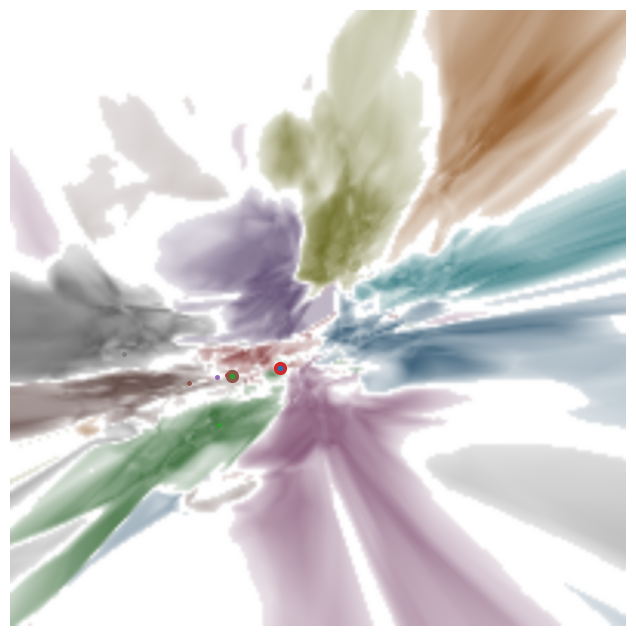

In [39]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
showList = [5645,9078,12673,14647,24758,36854,39833]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5419.00it/s]


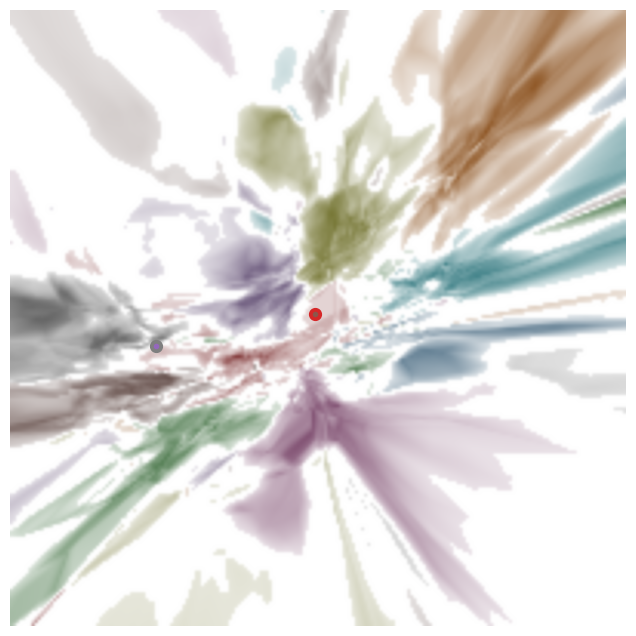

In [64]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
showList = [22489,24758,]


#  
#  
#  

#  
#  28428,
#  31156,
#  36854,
#  38741,
#  39833,
#  41478,
#  46503,
#  48685]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(representation,I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3880.02it/s]


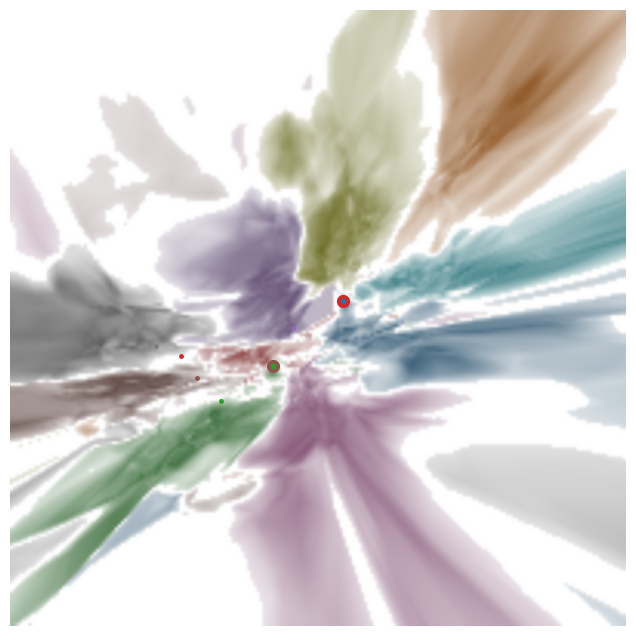

In [36]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
# showList = [5645,
#  9078,
#  9132,
#  12673,
#  14647,
#  18387,
#  18957,
#  22489,
#  24758,
#  28428,
#  31156,
#  36854,
#  38741,
#  39833,
#  41478,
#  46503,
#  48685]
showList = [5645,9078,12673,14647,24758,36854,39833]


#  
#  
#  
#  
#  
#  
#  
#  

#  
#  
#  
#  
#  48685]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(representation,I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9544.01it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

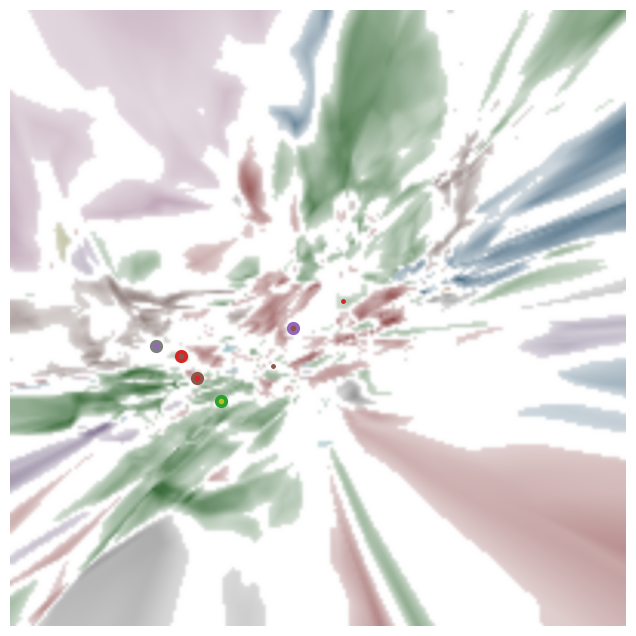

In [37]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
# showList = [5645,
#  9078,
#  9132,
#  12673,
#  14647,
#  18387,
#  18957,
#  22489,
#  24758,
#  28428,
#  31156,
#  36854,
#  38741,
#  39833,
#  41478,
#  46503,
#  48685]
showList = [5645,9078,12673,14647,24758,36854,39833]


#  
#  
#  
#  
#  
#  
#  
#  

#  
#  
#  
#  
#  48685]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(representation,I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3509.88it/s]


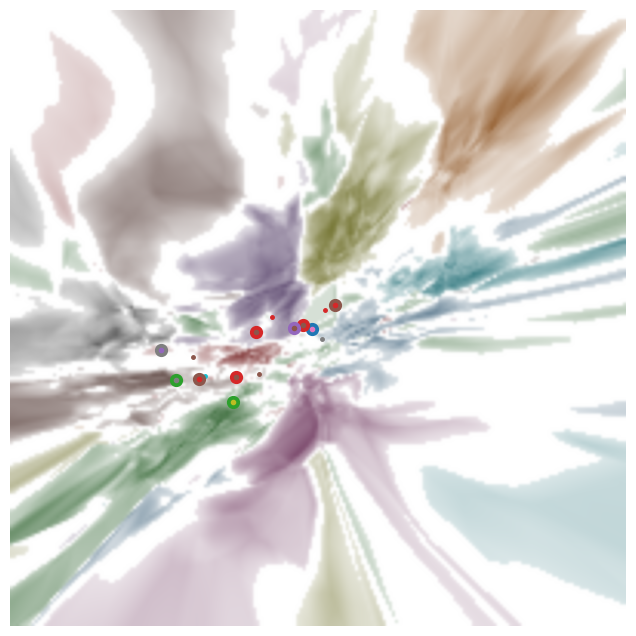

In [38]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(representation,I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [2]:
import json
import os
from singleVis.SingleVisualizationModel import SingleVisualizationModel
from singleVis.projector import TimeVisProjector
# model = VisModel(ENCODER_DIMS, DECODER_DIMS)
model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

NameError: name 'predict_label_diff_indicates' is not defined

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9403.32it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

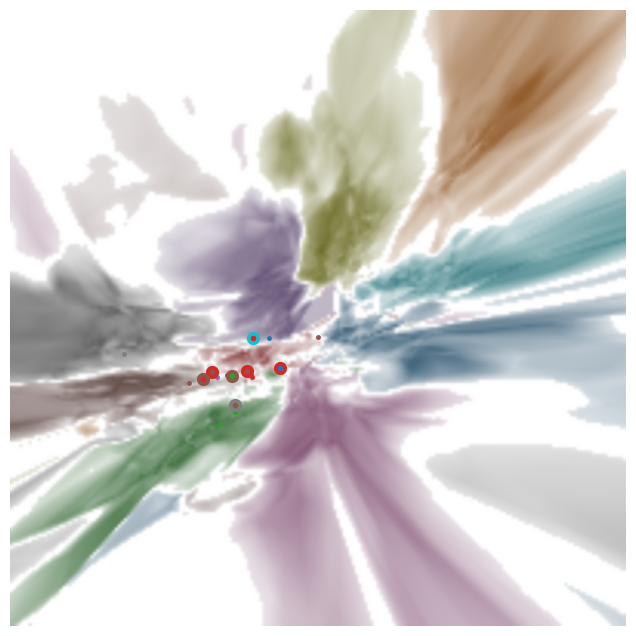

In [10]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data,I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))



In [17]:
predict_label_diff_indicates

[5645,
 9078,
 9132,
 12673,
 14647,
 18387,
 18957,
 22489,
 24758,
 28428,
 31156,
 36854,
 38741,
 39833,
 41478,
 46503,
 48685]

In [23]:
need_drae = [14647,
 18387,
 18957,
 22489,
 24758,
 28428,
 31156,
 36854,
 38741,
 39833,
 41478,
 46503,
 48685]

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9304.86it/s]


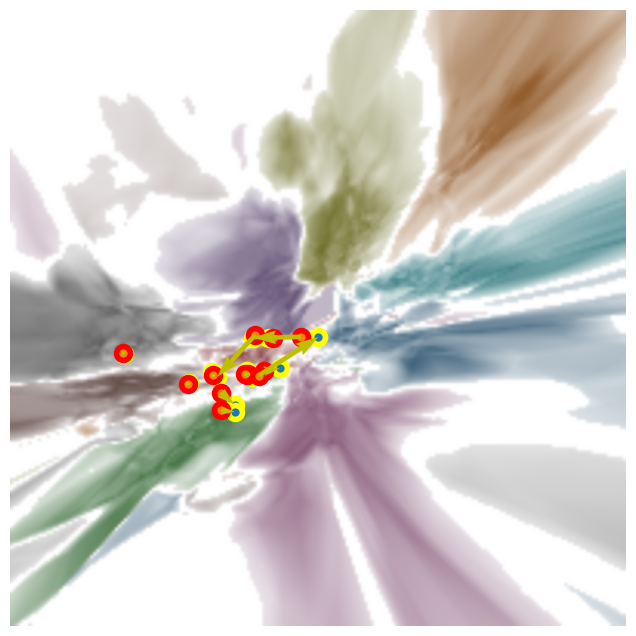

In [25]:
vis.savefig_trajectory(200, ref_provider.train_representation(150)[need_drae], '','',ref_provider.train_representation(200)[need_drae],'','',REF_PATH)

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3218.96it/s]


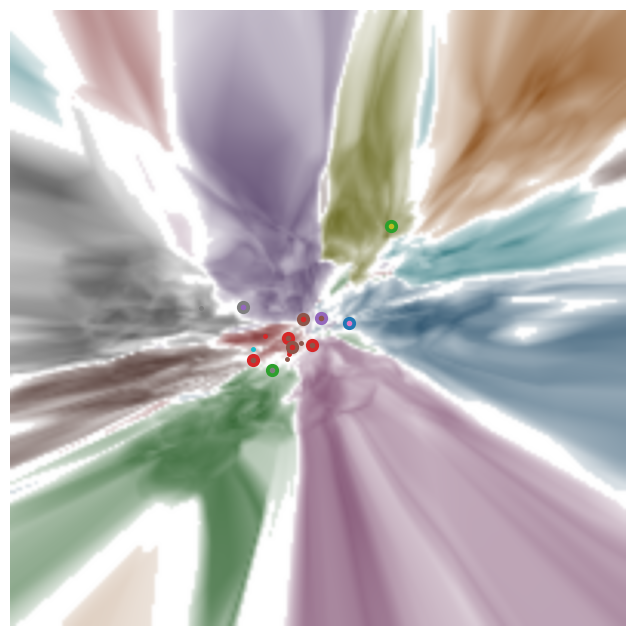

In [14]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(200),I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [6]:
absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates = gen.subsetClassify(35, 0.5)
diff_combine_same = np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates), axis=0)
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, tar_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, ref_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[predict_label_diff_indicates], tar_train_data[predict_label_diff_indicates])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, tar_train_data[diff_combine_same])))


absolute alignment indicates number: 51 label diff indicates number: 17 confidence diff indicates number: 12
RBF Kernel CKA, between diff subset: 0.9999986883213225
RBF Kernel CKA, between diff subset: 0.945861601405903
RBF Kernel CKA, between diff subset: 0.9457883366104397
RBF Kernel CKA, between diff subset: 0.8951524855774078
RBF Kernel CKA, between diff subset: 0.9999986883213225


In [23]:
len(diff_combine_same)

68

In [24]:
len(predict_label_diff_indicates)

17

In [20]:
need_update_arr = np.arange(51,len(diff_combine_same))

In [21]:
need_update_arr

array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

range(1, 101, 2)

In [12]:
# len(absolute_alignment_indicates)
aaa[:51]

array([[ 0.4438144 ,  0.25794092,  0.88561094, ..., -0.30997425,
         0.04925713,  0.7036765 ],
       [ 1.6506764 ,  0.62257606,  0.77443874, ...,  0.6457486 ,
         0.78697693,  1.9612937 ],
       [ 1.9230452 ,  1.8043541 ,  1.0690829 , ...,  1.2825058 ,
         2.058473  ,  2.411501  ],
       ...,
       [ 3.0967503 ,  0.83601546,  0.6276946 , ...,  0.3334073 ,
         0.04557479,  0.7800593 ],
       [ 0.29652357,  2.2157164 ,  1.0826873 , ...,  2.091645  ,
         1.8267734 ,  1.8171103 ],
       [ 2.123877  ,  1.9573641 ,  1.6897701 , ...,  1.3778095 ,
         2.8267016 ,  3.128074  ]], dtype=float32)

In [9]:
ref_train_data[absolute_alignment_indicates]

array([[0.35264334, 0.25828406, 0.83623934, ..., 0.        , 0.20785208,
        0.60769653],
       [1.7937965 , 0.5171929 , 0.2944022 , ..., 0.88652   , 1.0262028 ,
        1.7159932 ],
       [1.2522422 , 1.998488  , 1.3770924 , ..., 0.93216276, 1.8701797 ,
        2.7967405 ],
       ...,
       [2.7049246 , 0.6912097 , 0.3405223 , ..., 0.5076878 , 0.05851028,
        0.56205   ],
       [0.        , 1.9117651 , 1.4406421 , ..., 1.7921157 , 1.6261466 ,
        1.8802838 ],
       [1.8142302 , 1.6700609 , 1.9396539 , ..., 1.6751497 , 2.6756046 ,
        2.865216  ]], dtype=float32)

In [8]:
aaa

array([[ 0.4438144 ,  0.25794092,  0.88561094, ..., -0.30997425,
         0.04925713,  0.7036765 ],
       [ 1.6506764 ,  0.62257606,  0.77443874, ...,  0.6457486 ,
         0.78697693,  1.9612937 ],
       [ 1.9230452 ,  1.8043541 ,  1.0690829 , ...,  1.2825058 ,
         2.058473  ,  2.411501  ],
       ...,
       [ 1.2586628 , -0.02370401,  0.35129252, ...,  0.12940982,
         0.5937384 ,  0.4538625 ],
       [ 0.12163609,  1.2681662 ,  0.43215007, ...,  0.61959136,
        -0.26734826,  0.27205062],
       [-0.2988844 ,  1.0104567 ,  0.21589582, ...,  0.538526  ,
        -0.14185655, -0.20807993]], dtype=float32)

In [14]:
absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates = gen.subsetClassify(35, 1)

absolute alignment indicates number: 405 label diff indicates number: 17 confidence diff indicates number: 12


In [4]:
aaa

tensor([[ 3.0787e-01,  4.5586e-01,  1.2183e+00,  ...,  9.7048e-03,
          3.6762e-01,  9.9860e-02],
        [ 6.7021e-01,  2.3573e-02,  9.6027e-03,  ...,  9.2427e-05,
          8.9656e-01,  8.8440e-04],
        [ 0.0000e+00,  1.0089e-02,  1.1115e-02,  ...,  1.4065e+00,
          4.0381e-01,  0.0000e+00],
        ...,
        [-2.8396e-01,  2.0677e+00,  6.0495e-01,  ...,  4.7041e-01,
          1.5229e+00, -1.9884e-01],
        [ 1.5869e+00,  5.3166e-01,  1.1167e+00,  ...,  5.5588e-01,
          1.4619e+00, -1.5788e+00],
        [-3.7586e-01,  9.3878e-02, -2.0133e+00,  ...,  5.2337e-01,
          1.6253e+00,  1.2470e+00]], grad_fn=<CatBackward0>)

In [5]:
aaa

tensor([[ 3.0787e-01,  4.5586e-01,  1.2183e+00,  ...,  9.7048e-03,
          3.6762e-01,  9.9860e-02],
        [ 6.7021e-01,  2.3573e-02,  9.6027e-03,  ...,  9.2427e-05,
          8.9656e-01,  8.8440e-04],
        [ 0.0000e+00,  1.0089e-02,  1.1115e-02,  ...,  1.4065e+00,
          4.0381e-01,  0.0000e+00],
        ...,
        [-4.6379e-01, -3.9944e-01,  3.2981e-01,  ...,  4.5481e-01,
         -1.9631e+00,  1.5185e+00],
        [-1.1161e+00, -1.7232e+00, -9.9265e-01,  ..., -4.2883e-02,
         -1.0176e+00,  1.1383e+00],
        [-2.5949e-01, -8.4106e-02,  4.6334e-01,  ..., -4.1069e-01,
          2.6556e-01, -9.1836e-01]], grad_fn=<CatBackward0>)

In [60]:
import torch
import numpy as np
from scipy.spatial.distance import pdist

# def rbf_kernel(X, Y, gamma):
#     X_norms = (X ** 2).sum(dim=1, keepdim=True)
#     Y_norms = (Y ** 2).sum(dim=1, keepdim=True)
#     K = torch.exp(-gamma * (X_norms + Y_norms.T - 2 * torch.mm(X, Y.T)))
#     return K

def centering(K):
    n = K.shape[0]
    unit = torch.ones([n, n])
    I = torch.eye(n)
    H = I - unit / n
    K = torch.tensor(K)
    return torch.matmul(torch.matmul(H, K), H)

# def rbf(X, sigma=None):
#         GX = np.dot(X, X.T)
#         KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
#         if sigma is None:
#             mdist = np.median(KX[KX != 0])
#             sigma = math.sqrt(mdist)
#         KX *= - 0.5 / (sigma * sigma)
#         KX = np.exp(KX)
#         return KX

def rbf(X, sigma=None):
    # X = torch.tensor(X)
    GX = torch.matmul(X, X.T)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX)
    return KX


def kernel_HSIC(X, Y, sigma):
    K_X = centering(rbf(X, sigma))
    K_Y = centering(rbf(Y, sigma))
    hsic = torch.sum(K_X * K_Y)
    return hsic.item()

def rbf_kernel(X, sigma=None):
    # X = torch.tensor(X)
    GX = torch.matmul(X, X.T)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX)
    return KX


def cka(X, Y, sigma=None):
    K_X = centering(rbf(X, sigma))
    K_Y = centering(rbf(Y, sigma))
    hsic = torch.sum(K_X * K_Y)
    return hsic.item()
    
X = torch.randn(100, 10)
Y = torch.randn(100, 10)

cka_value = cka(X, Y)

def objective(Y, X=X, gamma=None):
    K_xx = rbf_kernel(X, gamma)
    K_yy = rbf_kernel(Y, gamma)
    K_xy = kernel_HSIC(X, Y, gamma)
    cka = torch.mean(K_xy) / torch.sqrt(torch.mean(K_xx) * torch.mean(K_yy))
    return -cka

from torch.optim import Adam

Y = torch.randn(100, 10, requires_grad=True)
optimizer = Adam([Y], lr=1e-2)

for i in range(10):
    loss = objective(Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)

Y = Y.detach().numpy()

print('RBF Kernel CKA, between same subset: {}'.format(cka(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(cka(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


TypeError: new(): data must be a sequence (got float)

In [53]:
import torch
import numpy as np
from scipy.spatial.distance import pdist

def rbf_kernel(X, Y, gamma):
    X_norms = (X ** 2).sum(dim=1, keepdim=True)
    Y_norms = (Y ** 2).sum(dim=1, keepdim=True)
    K = torch.exp(-gamma * (X_norms + Y_norms.T - 2 * torch.mm(X, Y.T)))
    return K


def cka(X, Y, gamma=1e-2):
    K_xx = rbf_kernel(X, X, gamma)
    K_yy = rbf_kernel(Y, Y, gamma)
    K_xy = rbf_kernel(X, Y, gamma)
    cka = torch.mean(K_xy) / torch.sqrt(torch.mean(K_xx) * torch.mean(K_yy))
    return cka.item()
    
X = torch.randn(100, 10)
Y = torch.randn(100, 10)

cka_value = cka(X, Y)

def objective(Y, X=X, gamma=1e-2):
    K_xx = rbf_kernel(X, X, gamma)
    K_yy = rbf_kernel(Y, Y, gamma)
    K_xy = rbf_kernel(X, Y, gamma)
    cka = torch.mean(K_xy) / torch.sqrt(torch.mean(K_xx) * torch.mean(K_yy))
    return -cka

from torch.optim import Adam

Y = torch.randn(100, 10, requires_grad=True)
optimizer = Adam([Y], lr=1e-2)

for i in range(10):
    loss = objective(Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)

Y = Y.detach().numpy()

print('RBF Kernel CKA, between same subset: {}'.format(cka(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(cka(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))


tensor(-0.9984, grad_fn=<NegBackward0>)
tensor(-0.9985, grad_fn=<NegBackward0>)
tensor(-0.9987, grad_fn=<NegBackward0>)
tensor(-0.9988, grad_fn=<NegBackward0>)
tensor(-0.9989, grad_fn=<NegBackward0>)
tensor(-0.9990, grad_fn=<NegBackward0>)
tensor(-0.9991, grad_fn=<NegBackward0>)
tensor(-0.9992, grad_fn=<NegBackward0>)
tensor(-0.9993, grad_fn=<NegBackward0>)
tensor(-0.9994, grad_fn=<NegBackward0>)
RBF Kernel CKA, between same subset: 0.7649381160736084
RBF Kernel CKA, between diff subset: 0.882797122001648
RBF Kernel CKA, between diff subset: 0.8677344918251038
RBF Kernel CKA, between same+diff subset: 0.8875225782394409


In [ ]:
sss = cka(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same],)

In [ ]:

# Step2: Computing the loss 
def compute_loss(X, Y, R):
    '''
    Inputs: 
       X: a matrix of dimension (m,n) where the columns are the English embeddings.
       Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
       R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
       L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # m is the number of rows in X
    m = len(X)

    # diff is XR - Y
    diff = np.dot(X, R) - Y

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)

    rows, columns = X.shape

    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient


# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps:int,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])
    # R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

   

        
    # train_steps = 100000
    for i in range(train_steps):
        if i%1000 == 0:
            loss = compute_loss(X,Y,R)
            print(f"iteration {i}, loss {loss}") 



        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)
       
        
         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R


In [ ]:
len(pred_diff_class)
ref_train_data = ref_provider.train_representation(200).squeeze()
ref_res_idx = list(zip(range(len(ref_prediction_res)),ref_prediction_res))
ref_scores_idx = list(zip(range(len(ref_scores)),ref_scores))

for i in range(len(pred_diff_class)):
    index = pred_diff_class[i]
    ###### find same prediction result in reference
    pred_res_in_target = tar_prediction_res[index]
    score = tar_scores[index]
    res_idx = list(filter(lambda x:x[1]==pred_res_in_target,ref_res_idx))

    res_idx = list(zip(*res_idx))[0]
    if len(res_idx):
        score_idx = list(filter(lambda x:np.logical_and(x[0] in res_idx,math.fabs(x[1] - score) < 0.1),ref_scores_idx))
        
        if len(score_idx):
            score_idx = list(zip(*score_idx))[0]
            if i%10 == 0:
                print('111',index, score_idx[0])
            ref_train_data[index] = ref_train_data[score_idx[0]]


    # print('res',pred_res_in_target, 'res',len(score_idx))

In [ ]:
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
S_for_same = align_embeddings(X, Y, 35000)

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

show_list = [pred_diff_class[0],pred_diff_class[1],pred_diff_class[7],pred_diff_class[8],pred_diff_class[14],pred_diff_class[16],
             pred_diff_class[18],
             pred_diff_class[20],pred_diff_class[25],pred_diff_class[29],pred_diff_class[30],pred_diff_class[32],pred_diff_class[33],
             pred_diff_class[42],pred_diff_class[43],pred_diff_class[44],pred_diff_class[45],
             ]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider , S_for_same,I, ref_train_data, projector, 200,[show_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
show_list = [pred_diff_class[0],pred_diff_class[1],pred_diff_class[7],pred_diff_class[8],pred_diff_class[14],pred_diff_class[16],
             pred_diff_class[18],
             pred_diff_class[20],pred_diff_class[25],pred_diff_class[29],pred_diff_class[30],pred_diff_class[32],pred_diff_class[33],
             pred_diff_class[42],pred_diff_class[43],pred_diff_class[44],pred_diff_class[45],
             ]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[show_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
# use prediction differenct subset train S_for_diff, use S_for_diff generate diff predict samples
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
R_for_same = align_embeddings(Y, X, 35000)

In [ ]:
# X = ref_train_data[diff_combine_same]
# Y = tar_train_data[diff_combine_same]
# S = align_embeddings(X, Y, 25000)
# X = ref_train_data[diff_combine_same]
# Y = tar_train_data[diff_combine_same]
# R = align_embeddings(Y, X, 25000)
# adjusted

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
diff_combine_same = np.concatenate((pred_diff_list, same_indicates), axis=0)

In [ ]:
# np.concatenate(ref_train_data[same_indicates], np.array([ref_train_data[index]])).shape


# samelist.append(ref_train_data[0])
# la = np.append(samelist, ref_train_data[0], axis=None) 
# la.shape   
# print(index,'RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same]))) 
stand = np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])                
for i in range(len(res_idx)):
    index = res_idx[i]
    samelist1 = ref_train_data[diff_combine_same]
    samelist1[0] = ref_train_data[index]

    if(stand - np_cka.kernel_CKA(samelist1, tar_train_data[diff_combine_same]) < 0.001):
        print(index,'RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(samelist1, tar_train_data[diff_combine_same])))

    

    

In [ ]:
def find_sta_CKA(res_idx, need_adjust_index,ref_representations, tar_representations, threthold):
    """
        res_idx: search subset
        need_adjust_index: index of the need adjusted sample
        ref_representations: reference representation sub set
        tar_representations: target representation sub set
        threthold: current CKA
    """
    stand_val = np_cka.kernel_CKA(ref_representations, tar_representations)           
    idx = []
    for i in range(len(res_idx)):
        index = res_idx[i]
        ref_representations[need_adjust_index] = ref_train_data[index]

        if (stand_val - np_cka.kernel_CKA(ref_representations, tar_representations) < threthold):
            idx.append(index)
    return idx

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(200),I), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[pred_diff_class],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
X = np.dot(ref_train_data[pred_diff_list],S_for_diff)
Y = tar_train_data[pred_diff_list]
print('RBF Kernel CKA, between np.dot(ref_train_data[pred_diff_list],S_for_diff) and tar_train_data[pred_diff_list]: {}'.format(np_cka.kernel_CKA(X, Y)))